Load Video

1.   Load from Google Drive in Colab
2.   Make directory



In [1]:
# # Google Colab import files in google drive
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools 

# !add-apt-repository -y ppa:alessandro-strada/ppa
  
# !apt-get update -qq

# !apt-get -y install -qq google-drive-ocamlfuse fuse 

# from google.colab import auth
# auth.authenticate_user()

# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()

# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p drive
# !google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Check the dirctory
!dir "drive/My Drive/FaceClusterer/"

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 36A9-D507

 C:\Users\dooms\Documents\Dev\FaceClusterer\doomsheart\drive\My Drive\FaceClusterer 디렉터리

2018-11-05  오후 04:12    <DIR>          .
2018-11-05  오후 04:12    <DIR>          ..
2018-11-05  오후 04:15    <DIR>          res
2018-11-06  오후 03:44    <DIR>          result
               0개 파일                   0 바이트
               4개 디렉터리  64,432,214,016 바이트 남음


In [63]:
!pip install tqdm
!pip install dlib
!pip install opencv-python
!pip install opencv-contrib-python
!pip install --upgrade imutils
!pip install cmake
!pip install dlib

from tqdm import tqdm
import cv2 as cv
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import shutil

BASE_DIR = 'drive/My Drive/FaceClusterer/'
RES_DIR = 'drive/My Drive/FaceClusterer/res/'

VIDEO_DIR = RES_DIR + 'vid/'
RESULT_DIR = 'drive/My Drive/FaceClusterer/result/'
# for unique
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d')
PROGRAM_START_TIME = '20180827'


def make_directory(_directory_name):
    if not os.path.exists(_directory_name):
        os.makedirs(_directory_name)
        
def get_area_of_frame_face_recognition(img, face_cascade):
    grayed_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # def detectMultiScale(self, image, scaleFactor=None, minNeighbors=None, flags=None, minSize=None, maxSize=None)
    face_area = face_cascade.detectMultiScale(image=grayed_img,scaleFactor=1.3,minNeighbors=5)
    return face_area
  
def get_frame(video_capture, frame):
    video_capture.set(cv.CAP_PROP_POS_FRAMES, frame)
    ret, img = video_capture.read()
    return img, frame, ret

def save_cropped_img(img, faces, frame):
    i = 0
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            iter = 0.2         
            while True:
                try:
                    face_img = img[int(y - h * iter): int(y + (1 + iter) * h),
                                   int(x - w * iter): int(x + (1 + iter) * w)]
                    if int(y - h * iter) < 0 or int(x - w * iter) < 0:
                        raise ValueError('range is false')
                    break
                except:
                    iter = iter * 0.8
                  #             cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", img[y:y + h, x: x + w])
            try:
                cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", cv.resize(face_img, (96, 96), interpolation=cv.INTER_AREA))
            except:
                print(int(y - h * iter))
                print(int(x - w * iter))
            i += 1
            
            
# this function show image and quit when press q or end
def show_img(img, faces):
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv.imshow('hello', img)
    if cv.waitKey(1) & 0xFF == ord('q'):
        return False
    else:
        return True
      
def ORB():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img2 = None
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
#     img2 = cv.drawKeypoints(img, kp, img2, (0, 0, 255), flags=0)
#     plt.imshow(img2)
    return kp, des 

def HarrisCorner():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(corners, cmap='gray')
    return coners



SyntaxError: unexpected EOF while parsing (<ipython-input-63-a3a12bfe61b1>, line 96)

In [70]:
PROGRAM_START_TIME = '20181108'
predictor_path = RES_DIR + "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
dets = detector(img, 1)
# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
def dlib_face_chip(img, frame_num):
    dets = detector(img, 1)
    if len(dets) == 0:
        return;
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(img, detection))
    images = dlib.get_face_chips(img, faces, size=320)
    for image in images:
        window.set_image(image)
        dlib.hit_enter_to_continue()
    im_list = []
    for face in faces:
        im_list.append(dlib.get_face_chip(img, face))
    if len(im_list) != 0:
        for i_, face_ in enumerate(im_list):
            try:
                cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame_num) + "_" + str(i_) + ".jpg", cv.resize(face_, (96, 96), interpolation=cv.INTER_AREA))
            except:
                print("cannot save : " + str(frame_num))
                print(face_)
                plt.imshow(face_)
    
SAVE_CROPPED_FACE_DIR = RESULT_DIR + 'Cropped_imgs/' + PROGRAM_START_TIME + '-' + VIDEO_FILE_NAME.split('.')[0]
make_directory(SAVE_CROPPED_FACE_DIR)

VIDEO_FILE_NAME = 'PowerUp.mp4'
m_video_capture = cv.VideoCapture(VIDEO_DIR + VIDEO_FILE_NAME)

CASCADE_DIR = RES_DIR + 'lbpcascade_frontalface_improved.xml'
m_face_cascade = cv.CascadeClassifier(CASCADE_DIR)

TOTAL_FRAME = m_video_capture.get(cv.CAP_PROP_FRAME_COUNT)
FRAME_STEP = 10
LOAD_FAIL = []
if len(os.listdir(SAVE_CROPPED_FACE_DIR)) == 0:
    for frame in tqdm(range(0, int(TOTAL_FRAME), FRAME_STEP)):
        img, frame, ret = get_frame(video_capture=m_video_capture, frame=frame)
        if not ret:
            LOAD_FAIL.append(frame)
            continue
        faces_area = dlib_face_chip(img, frame)
    if len(LOAD_FAIL) > 0:
        print("Fail to load %d of frame(s)" % len(LOAD_FAIL))
        print(LOAD_FAIL)
else:    
    print("Directory is not empty")
    print("Already extracted in %s" % PROGRAM_START_TIME)


 27%|█████▍              | 135/498 [03:38<10:14,  1.69s/it]


 54%|██████████▉         | 271/498 [07:26<06:09,  1.63s/it]


 82%|████████████████▎   | 407/498 [11:20<02:35,  1.70s/it]


100%|████████████████████| 498/498 [13:41<00:00,  1.15s/it]


In [3]:
SAVE_CROPPED_FACE_DIR = RESULT_DIR + 'Cropped_imgs/' + PROGRAM_START_TIME + '-' + VIDEO_FILE_NAME.split('.')[0]
make_directory(SAVE_CROPPED_FACE_DIR)

VIDEO_FILE_NAME = 'PowerUp.mp4'
m_video_capture = cv.VideoCapture(VIDEO_DIR + VIDEO_FILE_NAME)

CASCADE_DIR = RES_DIR + 'lbpcascade_frontalface_improved.xml'
m_face_cascade = cv.CascadeClassifier(CASCADE_DIR)

TOTAL_FRAME = m_video_capture.get(cv.CAP_PROP_FRAME_COUNT)
FRAME_STEP = 10
LOAD_FAIL = []
if len(os.listdir(SAVE_CROPPED_FACE_DIR)) == 0:
    for frame in tqdm(range(0, int(TOTAL_FRAME), FRAME_STEP)):
        img, frame, ret = get_frame(video_capture=m_video_capture, frame=frame)
        if not ret:
            LOAD_FAIL.append(frame)
            continue
        faces_area = get_area_of_frame_face_recognition(img=img, face_cascade=m_face_cascade)
        save_cropped_img(img, faces_area, frame)
    if len(LOAD_FAIL) > 0:
        print("Fail to load %d of frame(s)" % len(LOAD_FAIL))
        print(LOAD_FAIL)
else:    
    print("Directory is not empty")
    print("Already extracted in %s" % PROGRAM_START_TIME)

Directory is not empty
Already extracted in 20180827


In [4]:
SAVE_CROPPED_FACE_DIR

'drive/My Drive/FaceClusterer/result/Cropped_imgs/20180827-PowerUp'

In [5]:
!dir "drive/My Drive/FaceClusterer/result/Cropped_imgs/20180827-PowerUp/"

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 36A9-D507

 C:\Users\dooms\Documents\Dev\FaceClusterer\doomsheart\drive\My Drive\FaceClusterer\result\Cropped_imgs\20180827-PowerUp 디렉터리

2018-11-06  오후 03:48    <DIR>          .
2018-11-06  오후 03:48    <DIR>          ..
2018-11-06  오후 03:45             3,239 1000_0.jpg
2018-11-06  오후 03:45             3,769 1010_0.jpg
2018-11-06  오후 03:45             3,239 1010_1.jpg
2018-11-06  오후 03:45             3,092 1020_0.jpg
2018-11-06  오후 03:45             3,678 1020_1.jpg
2018-11-06  오후 03:45             4,701 1030_0.jpg
2018-11-06  오후 03:45             3,368 1030_1.jpg
2018-11-06  오후 03:45             3,540 1030_2.jpg
2018-11-06  오후 03:45             3,809 1090_0.jpg
2018-11-06  오후 03:45             3,314 1110_0.jpg
2018-11-06  오후 03:45             3,910 1200_0.jpg
2018-11-06  오후 03:44             4,416 120_0.jpg
2018-11-06  오후 03:45             3,898 1210_0.jpg
2018-11-06  오후 03:44             4,536 130_0.jpg
2018-11-06  오후 03:45             3,604 1340_0.

2018-11-06  오후 03:44             3,211 400_0.jpg
2018-11-06  오후 03:48             4,091 4030_0.jpg
2018-11-06  오후 03:48             4,249 4030_1.jpg
2018-11-06  오후 03:48             3,781 4050_0.jpg
2018-11-06  오후 03:48             4,224 4050_1.jpg
2018-11-06  오후 03:48             3,609 4050_2.jpg
2018-11-06  오후 03:48             4,071 4060_0.jpg
2018-11-06  오후 03:48             4,142 4070_0.jpg
2018-11-06  오후 03:48             4,192 4080_0.jpg
2018-11-06  오후 03:48             4,104 4090_0.jpg
2018-11-06  오후 03:48             4,331 4090_1.jpg
2018-11-06  오후 03:48             3,879 4090_2.jpg
2018-11-06  오후 03:48             3,896 4100_0.jpg
2018-11-06  오후 03:48             4,388 4100_1.jpg
2018-11-06  오후 03:48             4,115 4120_0.jpg
2018-11-06  오후 03:48             3,566 4300_0.jpg
2018-11-06  오후 03:44             3,262 430_0.jpg
2018-11-06  오후 03:48             3,789 4310_0.jpg
2018-11-06  오후 03:48             3,244 4320_0.jpg
2018-11-06  오후 03:48             3,619 4370_0.jpg
20

In [6]:
face_list = []
face_files = os.listdir(SAVE_CROPPED_FACE_DIR)

In [7]:
for face_file_name in tqdm(face_files):
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/' + face_file_name)
#     img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     img_blur = cv.GaussianBlur(img_gray, (3,3), 0)
#     img_sharp = cv.Laplacian(img_blur, cv.CV_64F)
#     corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     face_list.append(img_gray)
#     face_list.append(img_sharp.flatten())
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    face_list.append(rgb_img)

100%|███████████████████| 223/223 [00:01<00:00, 129.39it/s]


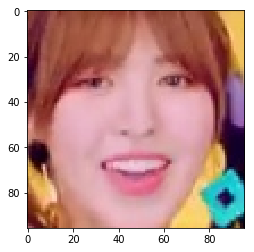

In [8]:
plt.imshow(face_list[5])

In [33]:
# import sys
import dlib
# from skimage import io
import cv2
# You can download the required pre-trained face detection model here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = RES_DIR + "shape_predictor_68_face_landmarks.dat"

# Take the image file name from the command line
file_name = RES_DIR + 'img/redvelvet.jpg'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

win = dlib.image_window()

# Take the image file name from the command line
# file_name = sys.argv[1]

# Load the image
image = cv.cvtColor(cv.imread(file_name), cv.COLOR_BGR2RGB)

# Run the HOG face detector on the image data
detected_faces = face_detector(image, 1)

print("Found {} faces in the image file {}".format(len(detected_faces), file_name))

# Show the desktop window with the image
win.set_image(image)

# Loop through each face we found in the image
for i, face_rect in enumerate(detected_faces):

    # Detected faces are returned as an object with the coordinates 
    # of the top, left, right and bottom edges
    print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))

    # Draw a box around each face we found
    win.add_overlay(face_rect)

    # Get the the face's pose
    pose_landmarks = face_pose_predictor(image, face_rect)

    # Draw the face landmarks on the screen.
    win.add_overlay(pose_landmarks)  
    # 	print(pose_landmarks)
dlib.hit_enter_to_continue()

Found 5 faces in the image file drive/My Drive/FaceClusterer/res/img/redvelvet.jpg
- Face #0 found at Left: 368 Top: 67 Right: 497 Bottom: 196
- Face #1 found at Left: 255 Top: 66 Right: 344 Bottom: 156
- Face #2 found at Left: 225 Top: 239 Right: 354 Bottom: 368
- Face #3 found at Left: 106 Top: 66 Right: 195 Bottom: 156
- Face #4 found at Left: 24 Top: 168 Right: 153 Bottom: 297


In [0]:
for j in detected_faces:
    print(j)

[(368, 67) (497, 196)]
[(255, 66) (344, 156)]
[(225, 239) (354, 368)]
[(106, 66) (195, 156)]
[(24, 168) (153, 297)]


In [41]:
face_file_path = file_name
predictor_path = predictor_model

# Load all the models we need: a detector to find the faces, a shape predictor
# to find face landmarks so we can precisely localize the face
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)

# Load the image using Dlib
img = dlib.load_rgb_image(face_file_path)

# Ask the detector to find the bounding boxes of each face. The 1 in the
# second argument indicates that we should upsample the image 1 time. This
# will make everything bigger and allow us to detect more faces.
dets = detector(img, 1)

num_faces = len(dets)
if num_faces == 0:
    print("Sorry, there were no faces found in '{}'".format(face_file_path))
    exit()

# Find the 5 face landmarks we need to do the alignment.
faces = dlib.full_object_detections()
for detection in dets:
    faces.append(sp(img, detection))

window = dlib.image_window()

# Get the aligned face images
# Optionally: 
# images = dlib.get_face_chips(img, faces, size=160, padding=0.25)
images = dlib.get_face_chips(img, faces, size=320)
for image in images:
    window.set_image(image)
    dlib.hit_enter_to_continue()

# It is also possible to get a single chip
im_list = []
for face in faces:
    im_list.append(dlib.get_face_chip(img, face))
print(im_list)

window.set_image(image)
dlib.hit_enter_to_continue()

[array([[[194, 185, 179],
        [242, 235, 229],
        [253, 249, 241],
        ...,
        [ 82,  67,  61],
        [ 80,  65,  61],
        [ 80,  65,  62]],

       [[157, 150, 142],
        [224, 217, 207],
        [249, 246, 235],
        ...,
        [ 83,  68,  63],
        [ 79,  64,  61],
        [ 77,  62,  59]],

       [[125, 118, 110],
        [193, 186, 176],
        [237, 232, 221],
        ...,
        [ 82,  66,  62],
        [ 77,  61,  58],
        [ 75,  59,  56]],

       ...,

       [[224, 217, 209],
        [225, 218, 210],
        [226, 219, 211],
        ...,
        [144, 118, 104],
        [158, 131, 119],
        [162, 137, 125]],

       [[223, 216, 208],
        [223, 216, 208],
        [224, 217, 209],
        ...,
        [169, 142, 129],
        [180, 153, 141],
        [178, 153, 141]],

       [[222, 215, 207],
        [222, 215, 207],
        [223, 216, 208],
        ...,
        [181, 154, 141],
        [183, 158, 145],
        [177, 152, 140]

In [51]:
croped_imgs = []
for i, d in enumerate(dets):
    croped_imgs.append(img[d.top():d.bottom(), d.left():d.right()])

In [52]:
croped_imgs

[array([[[ 52,  50,  55],
         [ 54,  49,  55],
         [ 60,  53,  61],
         ...,
         [105,  84,  81],
         [105,  86,  80],
         [112,  95,  87]],
 
        [[ 51,  46,  52],
         [ 52,  47,  53],
         [ 60,  53,  61],
         ...,
         [107,  88,  82],
         [ 98,  79,  73],
         [119, 102,  94]],
 
        [[ 48,  43,  49],
         [ 49,  44,  50],
         [ 55,  48,  56],
         ...,
         [110,  91,  85],
         [100,  81,  75],
         [117, 100,  92]],
 
        ...,
 
        [[202, 199, 192],
         [189, 189, 181],
         [184, 181, 174],
         ...,
         [ 35,  21,  21],
         [ 32,  18,  18],
         [ 32,  18,  18]],
 
        [[204, 199, 193],
         [185, 182, 175],
         [191, 186, 182],
         ...,
         [ 34,  18,  19],
         [ 35,  21,  21],
         [ 26,  12,  12]],
 
        [[203, 198, 192],
         [186, 183, 176],
         [189, 184, 180],
         ...,
         [ 34,  15,  17],
  

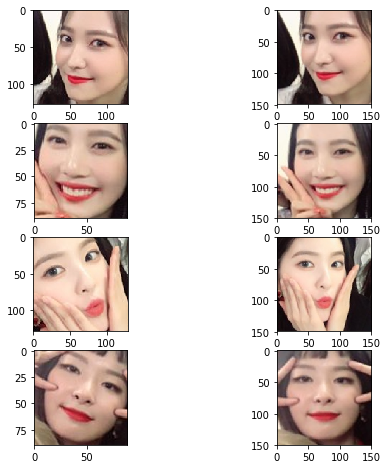

In [62]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 4
for i in range(4):
    img_original = croped_imgs[i]
    img_align = im_list[i]
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(img_original)
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(img_align)
plt.show()

In [ ]:
4